Testing biological calibration of the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('calibration*/outputSalishSea.nc')])
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)
    print(path.parent.stem)

calibration_Bio_20241105
calibration_PS_mL01


In [3]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [4]:
strait_of_georgia = [54,64,68,79,62,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [20,21,23,26]
fraser_river_plume = [75,80,81]

In [5]:
# Reading in Atlantis map

shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[strait_of_georgia]
sog_s_df = data_df.loc[sog_south]
sog_c_df = data_df.loc[sog_center]
sog_n_df = data_df.loc[sog_north]
ps_df = data_df.loc[puget_sound_main]
fr_df = data_df.loc[fraser_river_plume]

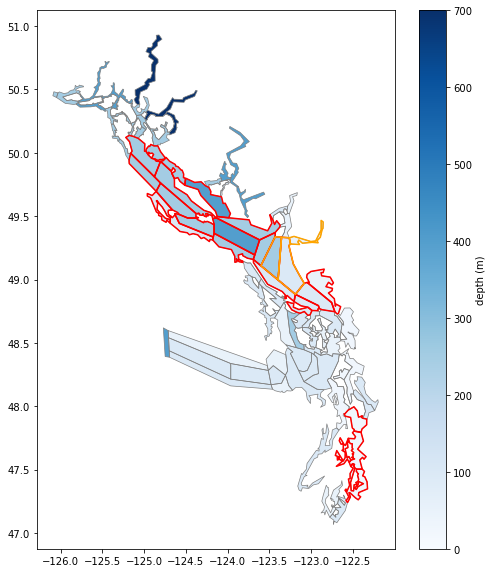

In [6]:
# Location Map
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
fr_df.boundary.plot(ax=ax, color='orange');
land_df.plot(ax=ax, color='white');

# Diatoms Biomass Comparisons

### Atlantis Model for Puget Sound (AMPS) Data

In [7]:
# Extracting AMPS diatom data
amps_filename = "AMPS_OUT_7.nc"
amps_data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/" + amps_filename
amps_data = xr.open_dataset(str(amps_data_file), decode_cf=True) #[t, box, z]

amps_time = amps_data.t
amps_volume = amps_data.volume
diatoms_amps_tbz = amps_data.Lrg_Phyto_N * amps_volume #convert to mg N 
diatoms_amps_tb = diatoms_amps_tbz[:,:,0:6].sum(axis=2)
diatoms_amps_t = diatoms_amps_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

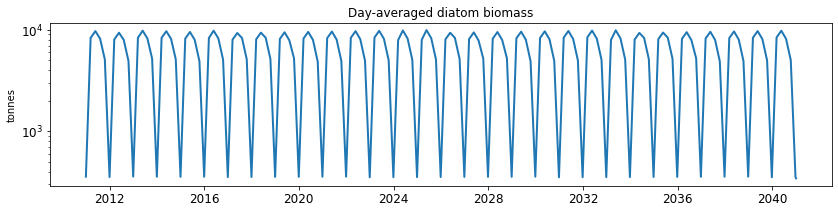

In [8]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(amps_time, diatoms_amps_t, linewidth = 2) #semilogy
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
#ax.legend(('Puget Sound Atlantis diatoms'), loc='best');

### SalishSeaCast Data

In [9]:
# SalishSeaCast daily averaged diatom data for 30 days in 2007
ssc_data = xr.open_dataset('/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc')
mesh = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

ssc_volume = (mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
diatoms_SSC_tzyx = ssc_data.diatoms # [t,z,y,x]
diatoms_SSC_tzyx = diatoms_SSC_tzyx * ssc_volume # convert from mmol m-3 to mmol
# Convert mmol N * 14.0067 mg/mmol 
diatoms_SSC_tzy = diatoms_SSC_tzyx.sum(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.sum(axis=2)
diatoms_SSC_t = diatoms_SSC_tz.sum(axis=1) * (14.0067) #convert to mg N

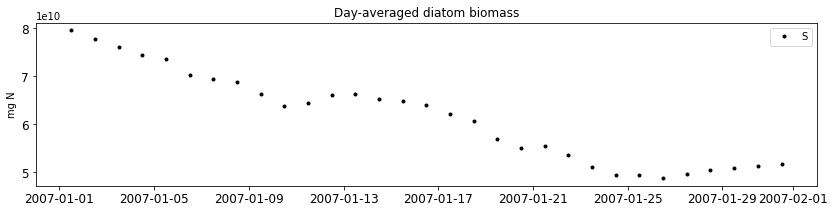

In [10]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.plot(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2) #semilogy
#ax.plot(ssam_time[5:37], diatoms_SSAM_t[5:37],'b.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms'), loc='best'); #'SSAM diatoms'

### SSAM Data

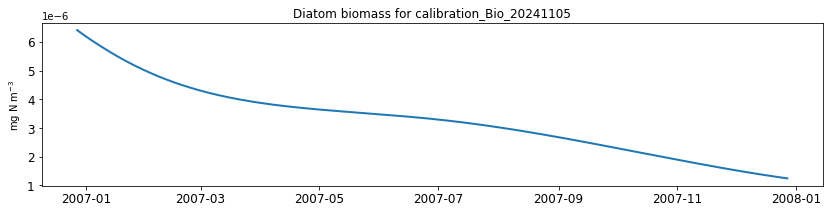

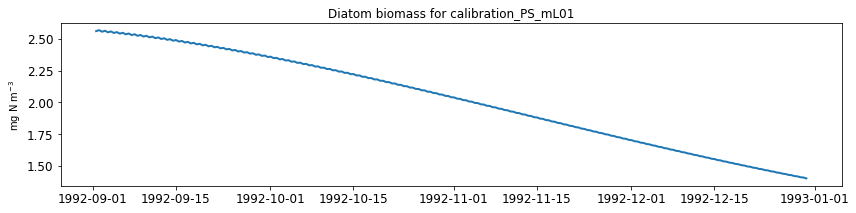

In [11]:
for scenario, label in zip(scenario_datasets,scenario_labels):
    fig, ax = plt.subplots(figsize = (14,3)) 
    var_tbl = scenario.Diatom_N[:,strait_of_georgia,0:6] * scenario.volume[:,strait_of_georgia,0:6]
    var_tb = var_tbl.sum(axis=2)
    ax.plot(scenario.t, scenario.Diatom_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    ax.set_title('Diatom biomass for '+label, fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)

Atlantis water column biomass is within the same order of magniutude for SoG. Most biomass reported earlier was found in the sediment and not in the water column. Picophytoplankton biomass is orders of magnitude higher. Susan suggests we investigate the biomass during the spring (May) as biomass during the winter (January) is typically quite low. Need to pull daily averages values from SalishSeaCast for spring.

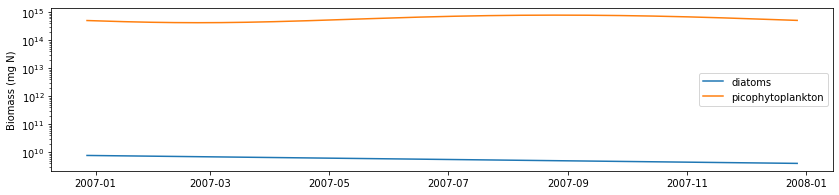

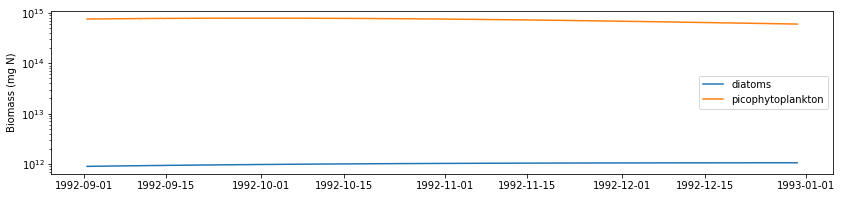

In [12]:
bio_group = groups.phytoplankton
location = strait_of_georgia
for scenario, label in zip(scenario_datasets,scenario_labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for species in bio_group:
        time = scenario.variables['t']
        biom_tbl = scenario.variables[bio_group[species]+'_N'][:,location,0:6] * scenario.volume[:,location,0:6]
        biom_tb = biom_tbl.sum(axis=2)
        biom_t = biom_tb.sum(axis=1)
        ax.semilogy(time,biom_t)
    ax.legend(bio_group)
    ax.set_ylabel('Biomass (mg N)');

# Diatom & Plankton Distribution

In [13]:
def plot_pelagic_depth(group, location, scenario_datasets, scenario_labels):

    fig = plt.figure(figsize=(18, 27), facecolor='white')
    gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1]) 

    depth = [450, 250, 100, 50, 25, 0] #700, 450, 

    for species in group:
        bio_index = (list(group).index(species))

        if bio_index < 4:
            position = 0, bio_index
        elif bio_index > 8: 
            position = 2, bio_index-8
        else :
            position = 1, bio_index-4

        ax = fig.add_subplot(gs[position])

        for data, label in zip(scenario_datasets, scenario_labels):
            pelagic_oiled_m3 = data.variables[group[species] + '_N'][len(data.t)-5:len(data.t),location,0:6]
            pelagic_oiled = pelagic_oiled_m3 * data.volume[len(data.t)-5:len(data.t),location,0:6]
            p_oiled = pelagic_oiled.mean(axis=1)
            p_oiled = p_oiled.mean(axis=0)
            ax.semilogx(p_oiled, depth,linewidth = 2) #color=line_colour, linestyle=line_type,
            #ax.pcolormesh(p_oiled[:,0], pelagic_oiled[0,:], cmap='RdBu') #,vmin=z_min, vmax=z_max
        ax.set_ylim(100, 0)  # decreasing depth
        ax.set_title(species)
        ax.set_ylabel('depth, m')
        ax.set_xlabel('mg N')
    ax.legend(scenario_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);


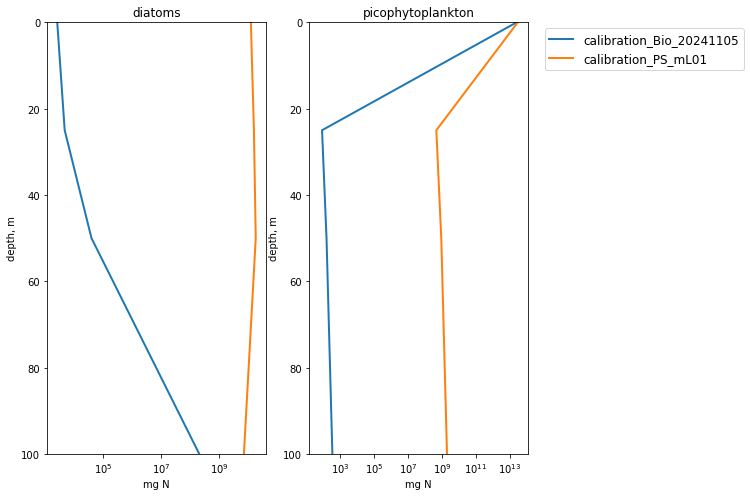

In [14]:
plot_pelagic_depth(groups.phytoplankton, groups.strait_of_georgia, scenario_datasets, scenario_labels) # water column only

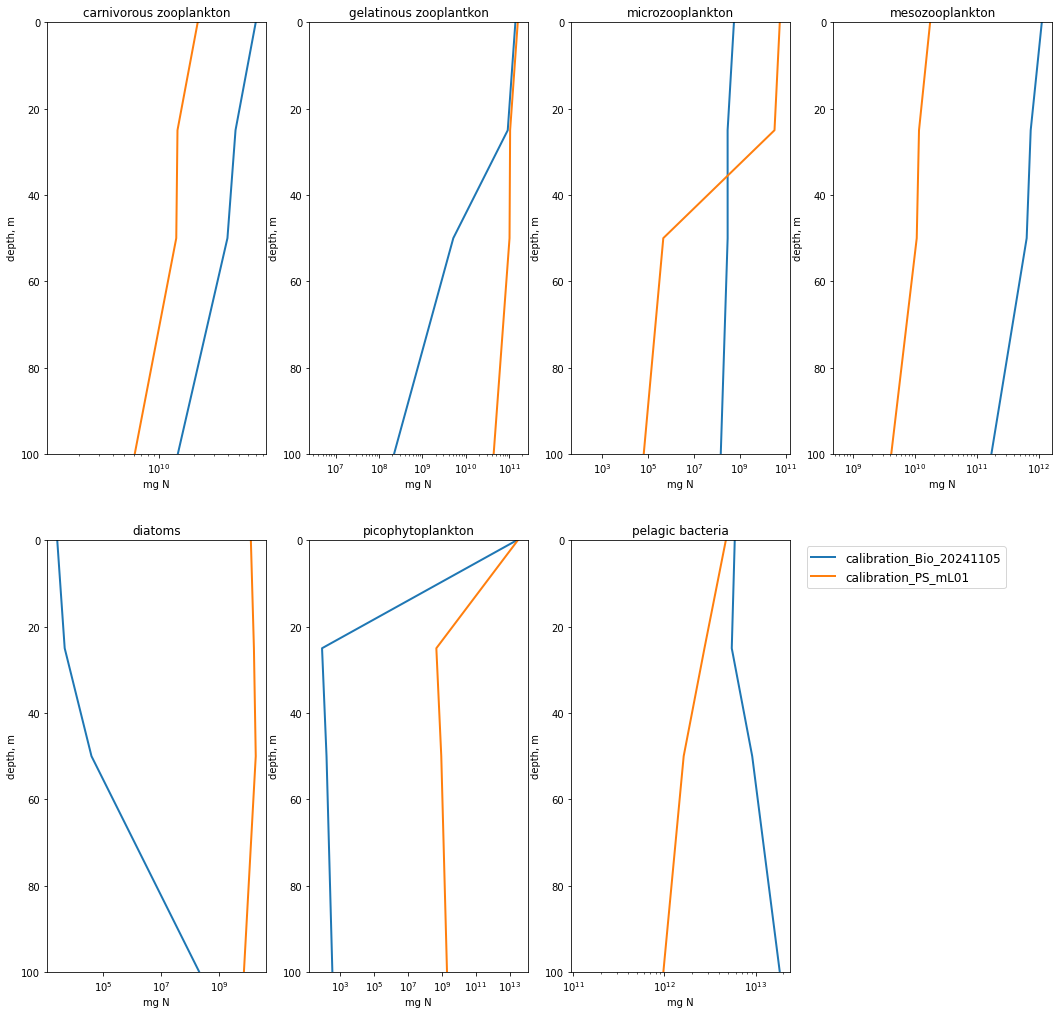

In [15]:
plot_pelagic_depth(groups.plankton, groups.strait_of_georgia, scenario_datasets, scenario_labels) # water column only

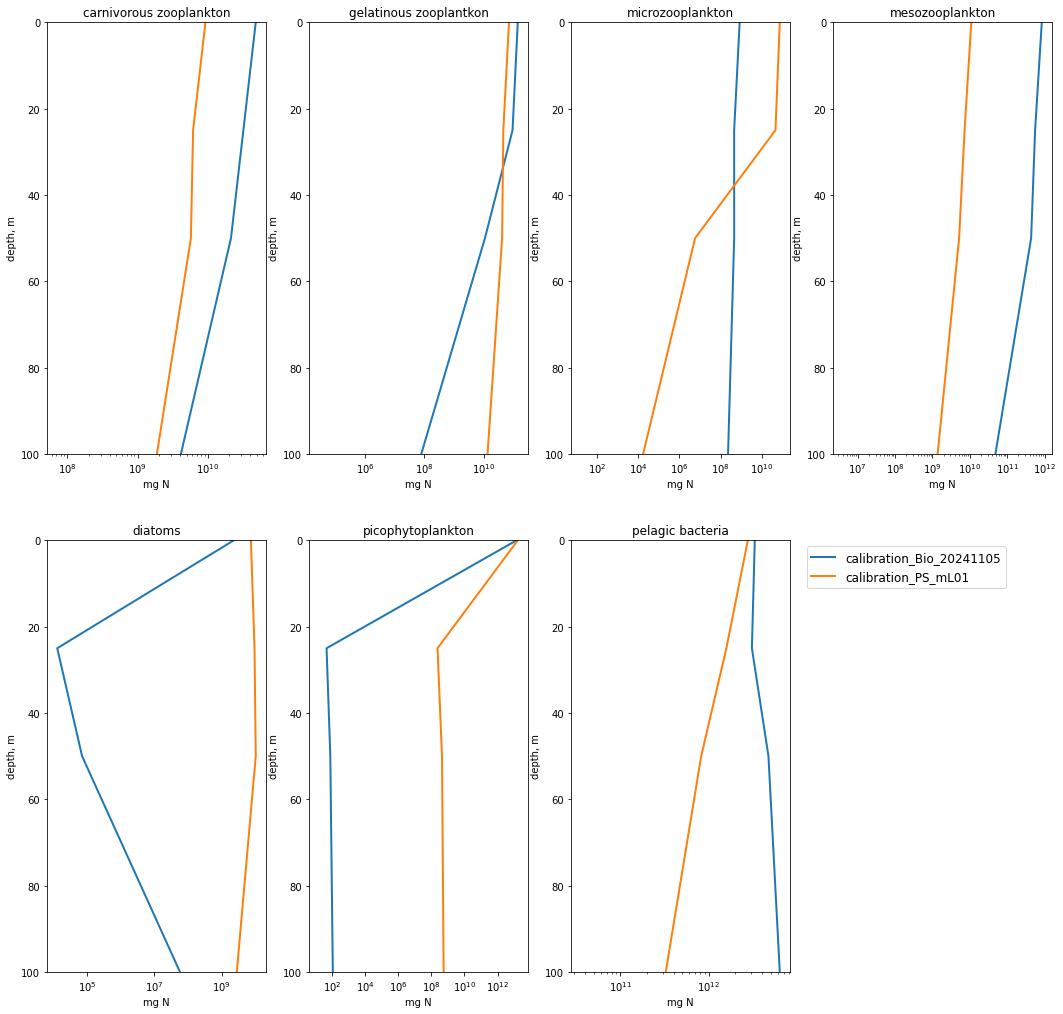

In [16]:
plot_pelagic_depth(groups.plankton, groups.salish_sea, scenario_datasets, scenario_labels) # water column only

### Surface values

In [17]:
def map_surface(variable_name, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 12), facecolor='white')
    gs = plt.GridSpec(2, len(scenario_datasets), height_ratios=[1, 3])

    position = 0
    
    for scenario, label in zip(scenario_datasets, scenario_labels):
        dVar_s = scenario.variables[variable_name][len(scenario.t)-10:len(scenario.t),:,5]
        scen = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0

        ax = fig.add_subplot(gs[1,position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, vmin=v_min, vmax=v_max, cax=cax, #norm=colors.LogNorm(vmin=1, vmax=data_df.old_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(label, fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white')
        position = position+1;

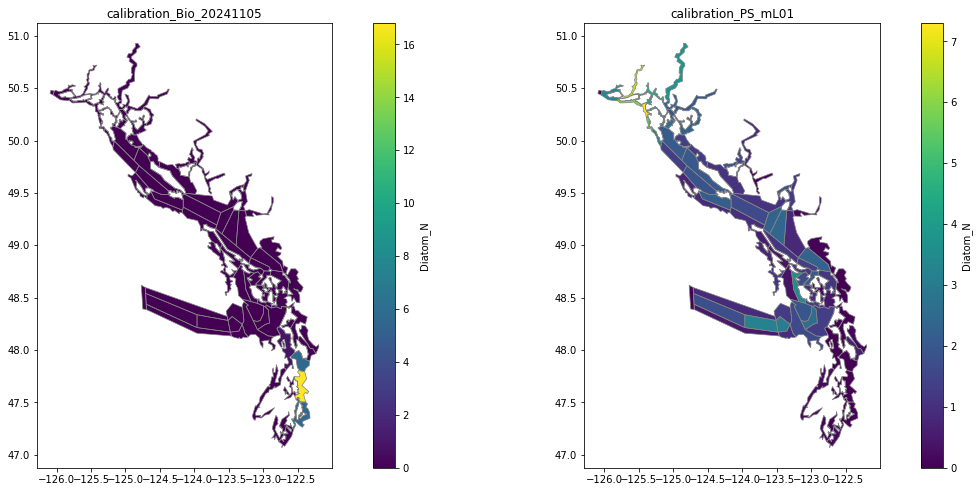

In [18]:
map_surface('Diatom_N')

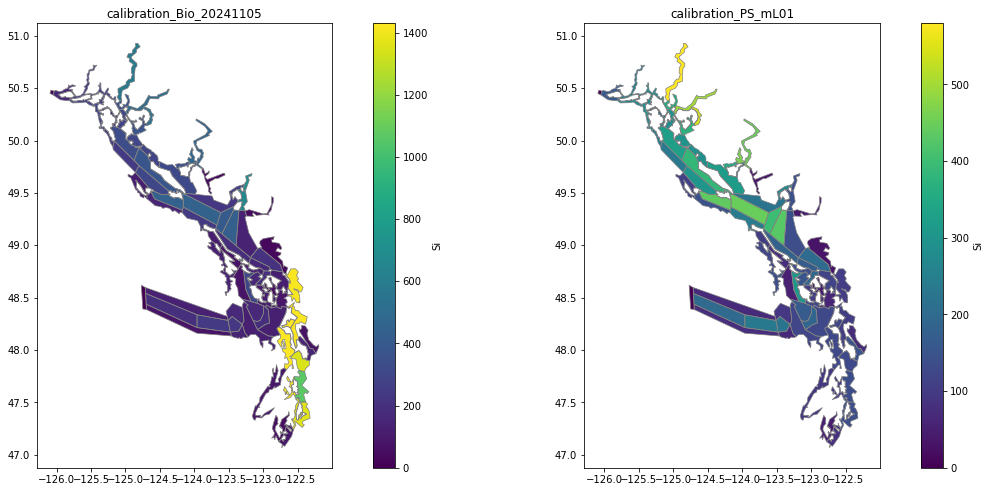

In [19]:
map_surface('Si')

Didn't originally appear that Silica is limiting, but mean across last 5 values in the run does indicate low Si in some boxes. Beth suggests we could still put silica into the deep water boundary boxes so that they can be advected into the system, given that the rivers are sources of silica in the Salish Sea, and there is no silica limitation in the system.

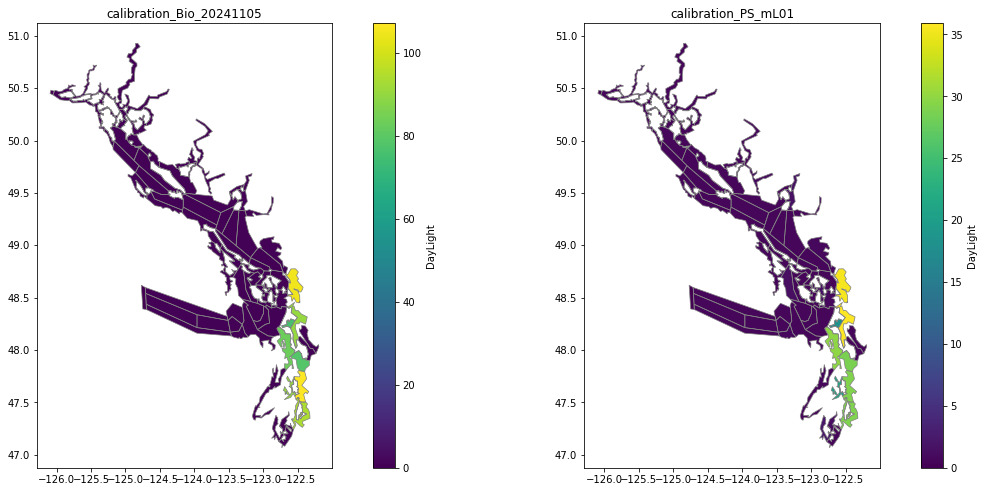

In [20]:
map_surface('DayLight')

Calibration run is set to time step of 0.5 days (Beth suggested sub-day time steps for Light). No improvement, but the new text is a shorter run than the comparison, so may need to do the same run times. 

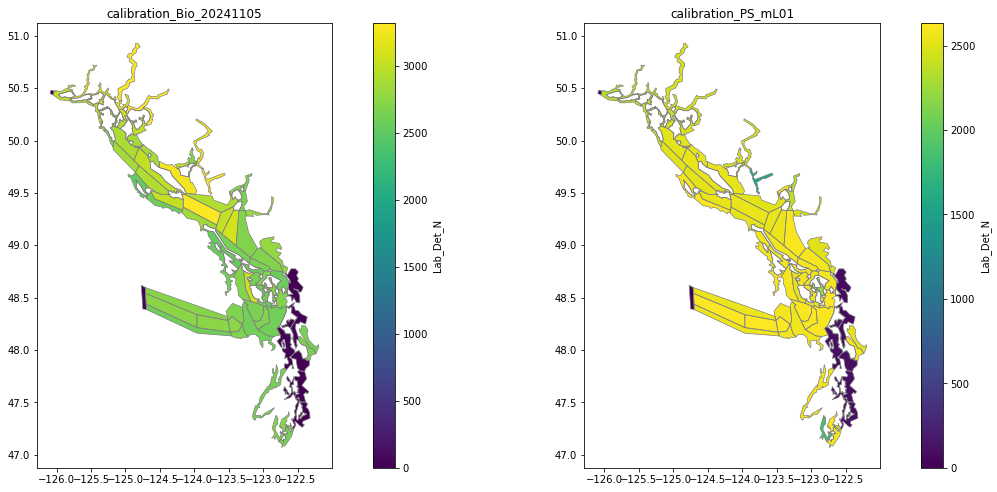

In [21]:
map_surface('Lab_Det_N')

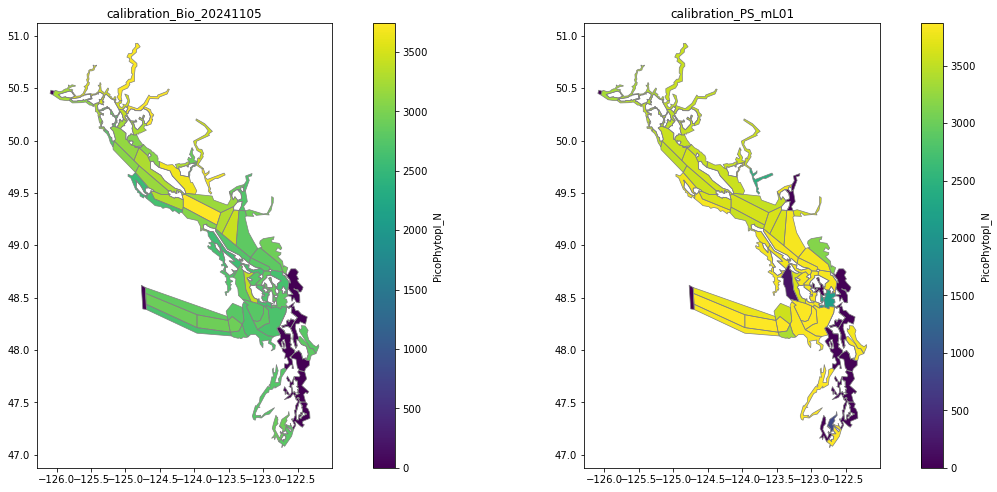

In [22]:
map_surface('PicoPhytopl_N')

There is very high detritus (Lab_det + Ref_Det) as well as Picos in the system compared to diatoms, which could be the source of the shading and reduction in light levels in the surface. Beth suggests to try scaling back the picos (inreasing their mortality). This might lead to more detritus, but there would be less standing stock to begin with, so maybe less detritus overall. 

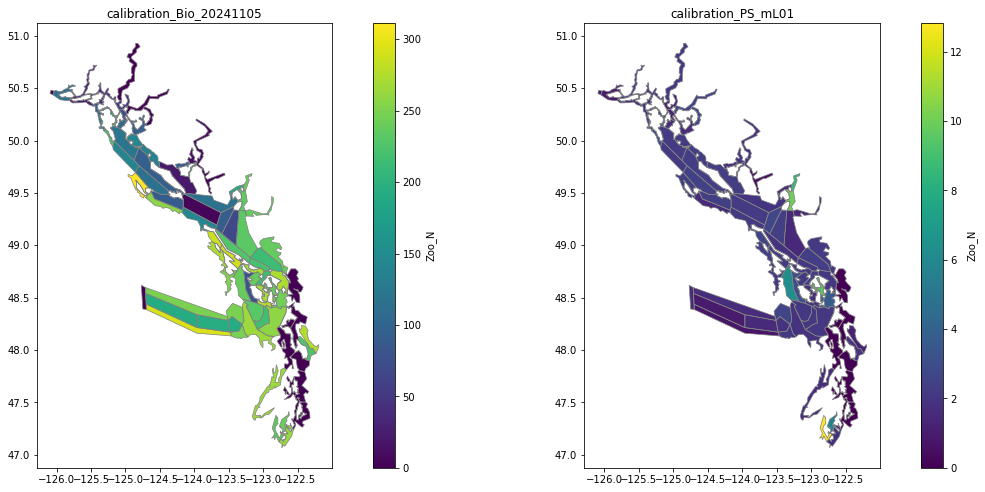

In [23]:
map_surface('Zoo_N')

# Light intensity

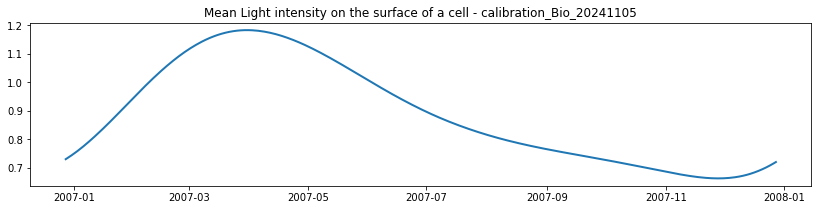

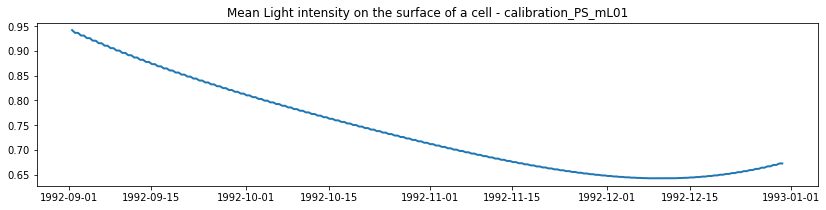

In [24]:
# Surface light
for scenario, label in zip(scenario_datasets,scenario_labels):
    Light_tb = scenario.DayLight[:,strait_of_georgia,5]
    Light_t = Light_tb.mean(axis=1)
    fig, ax = plt.subplots(figsize = (14,3)) 
    ax.plot(scenario.t, Light_t, linewidth = 2) #semilogy
    ax.set_title('Mean Light intensity on the surface of a cell - ' +label, fontsize = 12);

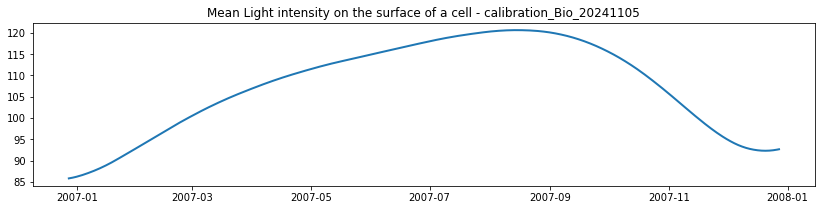

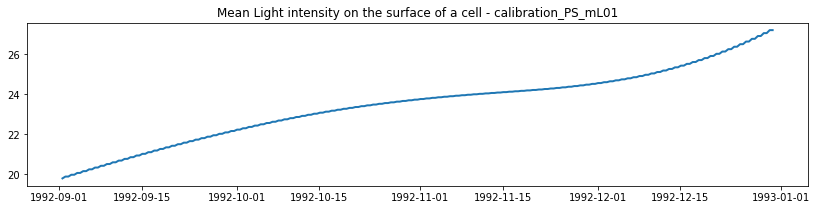

In [25]:
# Surface light
for scenario, label in zip(scenario_datasets,scenario_labels):
    Light_tb = scenario.DayLight[:,puget_sound_main,5]
    Light_t = Light_tb.mean(axis=1)
    fig, ax = plt.subplots(figsize = (14,3)) 
    ax.plot(scenario.t, Light_t, linewidth = 2) #semilogy
    ax.set_title('Mean Light intensity on the surface of a cell - ' +label, fontsize = 12);

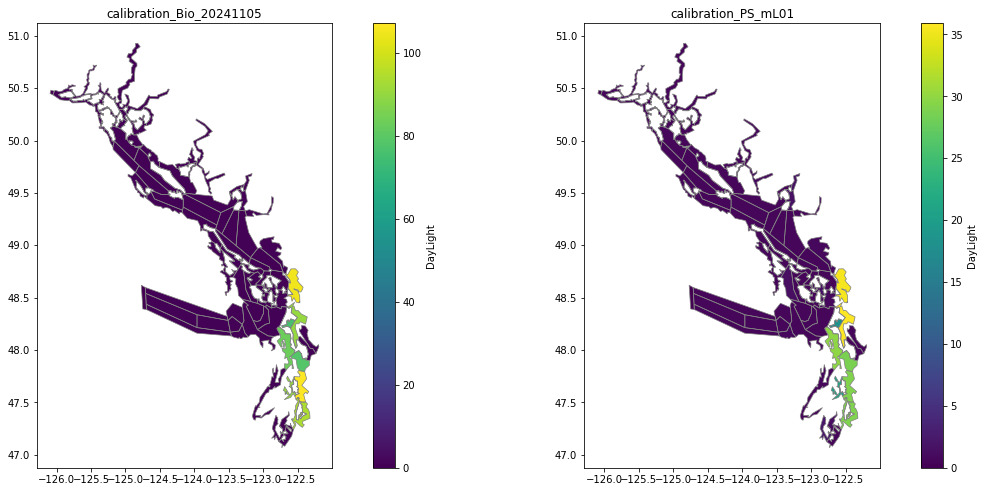

In [26]:
map_surface('DayLight')

### Light in the model for a 50-year control run

In [27]:
# 50y run
file_location = '/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/v6718_50y_20241105_start5475/outputSalishSea.nc'
test_50y = xr.open_dataset(str(file_location), decode_cf=True)

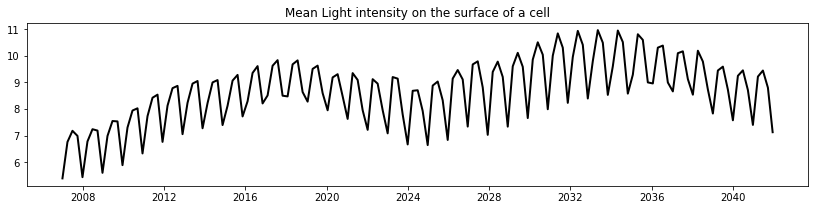

In [28]:
# Surface light
Light_tb = test_50y.DayLight[:,:,5]
Light_t = Light_tb.mean(axis=1)
fig, ax = plt.subplots(figsize = (14,3)) 
ax.plot(test_50y.t, Light_t, 'k', linewidth = 2) #semilogy
ax.set_title('Mean Light intensity on the surface of a cell', fontsize = 12);

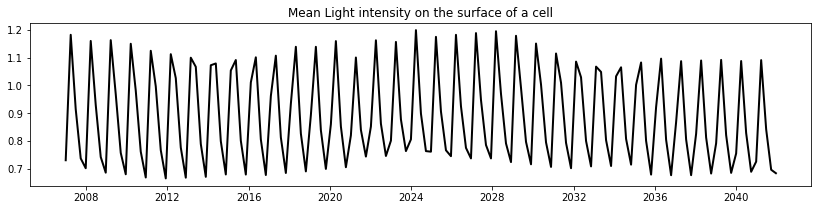

In [29]:
# Surface light
Light_tb = test_50y.DayLight[:,strait_of_georgia,5]
Light_t = Light_tb.mean(axis=1)
fig, ax = plt.subplots(figsize = (14,3)) 
ax.plot(test_50y.t, Light_t, 'k', linewidth = 2) #semilogy
ax.set_title('Mean Light intensity on the surface of a cell', fontsize = 12);

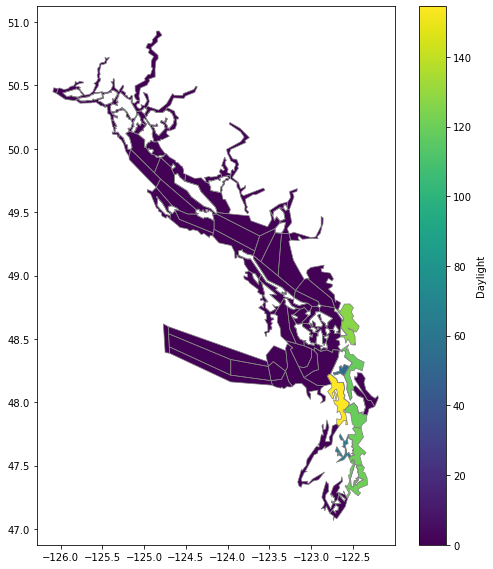

In [30]:
# Surface Light
plot_data = test_50y.DayLight[142,:,5]
data_df['plot_test2'] = plot_data 
land_df = data_df.loc[land_boxes]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_test2', ax=ax, cax=cax,#norm=colors.LogNorm(vmin=1, vmax=data_df.plot_test2.max()), #vmin=0, vmax=20, cmap=cm.Greens,
legend=True, legend_kwds={'label': 'Daylight'
},)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white');

# Wild salmon

In [31]:
def plot_numbers(bio_group, location):
    for scenario, label in zip(scenario_datasets, scenario_labels):
        fig, ax = plt.subplots(figsize = (14,3))
        for species in bio_group:
            time = scenario.variables['t']
            nums_tbl = scenario.variables[bio_group[species]+'3_Nums'][:,location,:]
            nums_tb = nums_tbl.sum(axis=2)
            nums_t = nums_tb.sum(axis=1)
            ax.plot(time,nums_t)
        ax.legend(bio_group)
        ax.set_title(label, fontsize = 12)
        ax.set_ylabel('Numbers');

In [37]:
def map_water_column(variable_name, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 12), facecolor='white')
    gs = plt.GridSpec(2, len(scenario_datasets), height_ratios=[1, 3])

    position = 0
    
    for scenario, label in zip(scenario_datasets, scenario_labels):
        dVar_s = scenario.variables[variable_name][len(scenario.t)-10:len(scenario.t),:,0:6]
        scen_tb = dVar_s.sum(axis=2)
        scen = scen_tb.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0

        ax = fig.add_subplot(gs[1,position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, vmin=v_min, vmax=v_max, cax=cax, norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()), #vmin=0, vmax=20, cmap=cm.Greens,
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(label, fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white')
        position = position+1;

In [33]:
def map_invertebrate_biomass(variable, v_min=None, v_max=None):
    
    fig = plt.figure(figsize=(18, 12), facecolor='white')
    gs = plt.GridSpec(2, len(scenario_datasets), height_ratios=[1, 3])

    position = 0

    for scenario, label in zip(scenario_datasets, scenario_labels):
        plot_data_tbl = (scenario.variables[variable + '_StructN'][len(scenario.t)-10:len(scenario.t),:,0:6] + scenario.variables[variable + '_ResN'][len(scenario.t)-10:len(scenario.t),:,0:6] * scenario.variables[variable + '_Nums'][len(scenario.t)-10:len(scenario.t),:,0:6])*20*5.7*(3.65/2.65)/1000000
        plot_data_tb = plot_data_tbl.sum(axis=2)
        plot_data = plot_data_tb.mean(axis=0)
        data_df['plot_data'] = plot_data 
        land_df = data_df.loc[land_boxes]

        ax = fig.add_subplot(gs[1,position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.95) 
        ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), vmin=v_min, vmax=v_max, #cmap=cm.Greens,
        legend=True, legend_kwds={'label': variable +' wet weight biomass (tonnes)'
        },)
        ax.set_title(label, fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white')
        position = position+1;

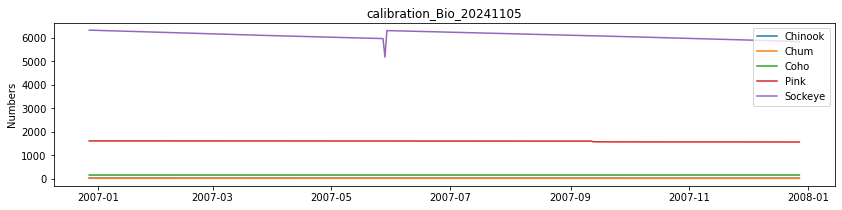

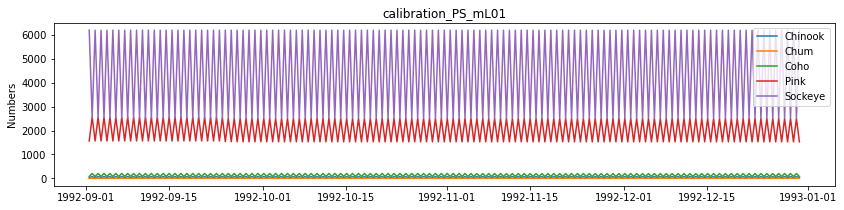

In [34]:
plot_numbers(groups.wild_salmon, strait_of_georgia)

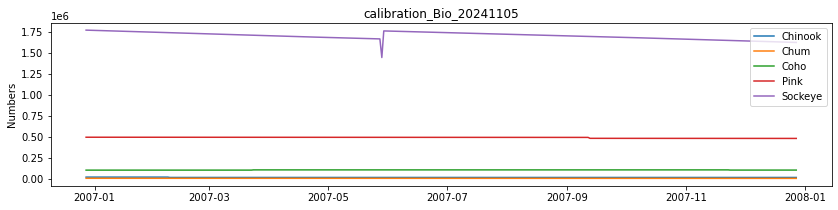

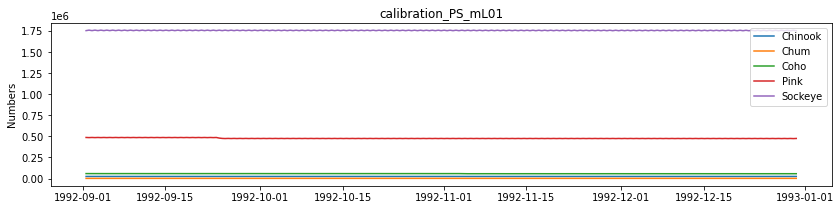

In [35]:
plot_numbers(groups.wild_salmon, puget_sound_main)

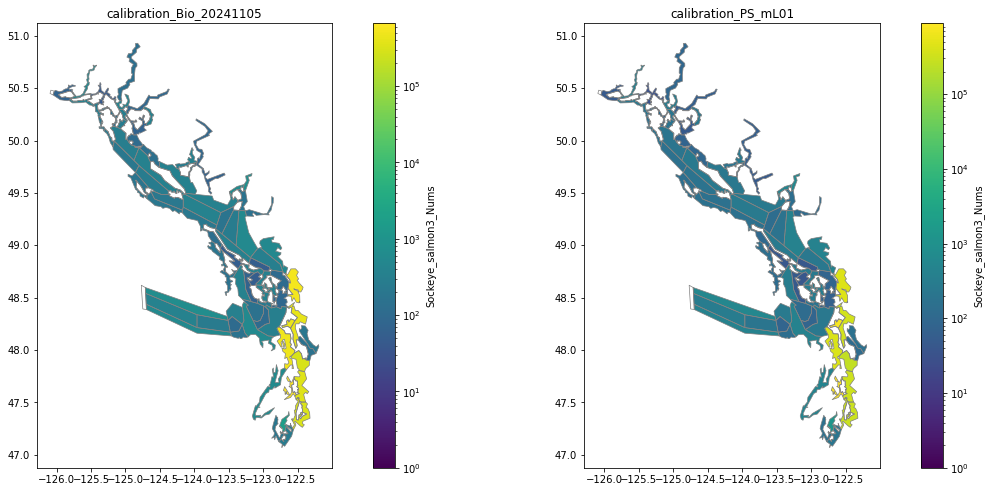

In [38]:
map_water_column('Sockeye_salmon3_Nums')

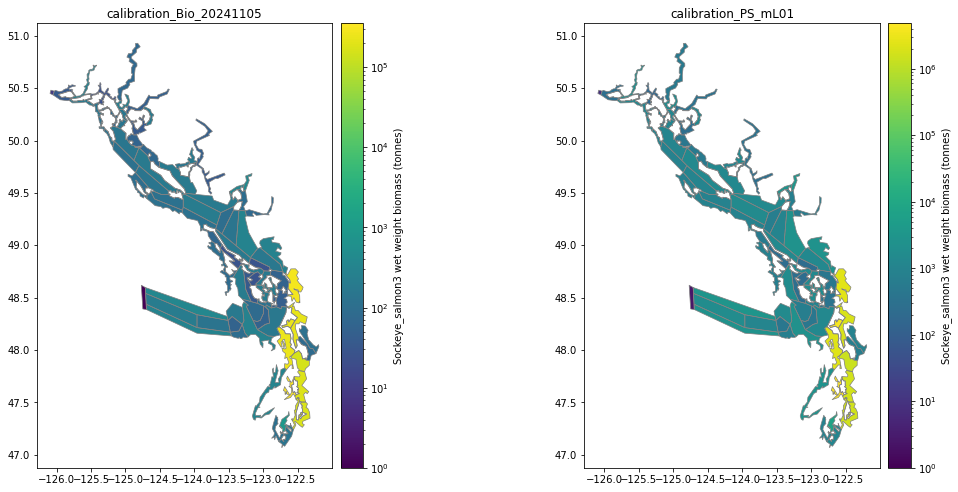

In [39]:
map_invertebrate_biomass('Sockeye_salmon3')

Now that we know we only really get diatoms in Puget Sound, this may help to explain why the larger biomass congregate in that area over time, possibly following food. Perhaps also check zooplankton biomass.

## Wild + hatchery salmon

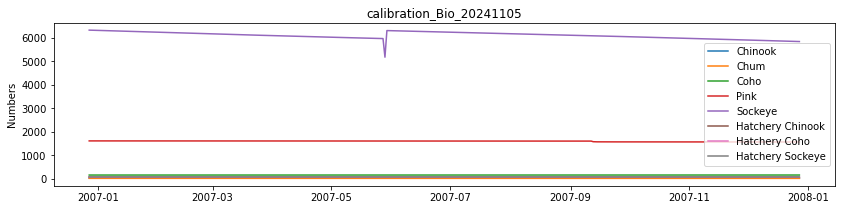

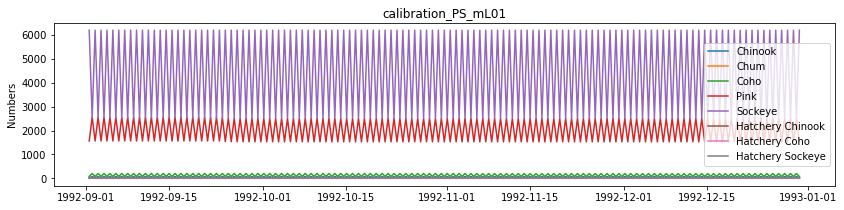

In [40]:
plot_numbers(groups.salmon, strait_of_georgia)

Calculate weight at age in wet weight (tons) to compare with Puget Sound data and with other data on these species in the literature. PSA team uses the following conversations 20  5.7 (redfield ratio) (3.65/2.65)/1000000

In [43]:
def compare_cohorts(bio_group, location):
    for scenario, label in zip(scenario_datasets,scenario_labels):   
        for species in bio_group:
            fig, ax = plt.subplots(figsize = (14,4), sharex='all')
            numCohorts = groups.cohorts[bio_group[species]]

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = scenario.variables[new_species + '_Nums'][:,location,:]
                o_structuralN_tbl = scenario.variables[new_species +'_StructN'][:,location,:]
                o_reservedN_tbl = scenario.variables[new_species +'_ResN'][:,location,:]

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl * o_numbers_tbl) *20*5.7*(3.65/2.65)/1000000
                o_weightatage_tb = o_weightatage_tbl.sum(axis=2)
                o_weightatage_t = o_weightatage_tb.sum(axis=1)

                ax.plot(scenario.t, o_weightatage_t, linewidth = 2)
        
            ax.set_title('Biomass of ' + str(bio_group[species])+' - '+label, fontsize = 12)
            ax.set_ylabel('Wet weight (tonnes) - ' + label, fontsize = 12)
            ax.tick_params(labelsize=11)
            ax.legend(['cohort 1','cohort 2','cohort 3','cohort 4','cohort 5','cohort 6','cohort 7','cohort 8','cohort 9','cohort 10',]) #loc='center left'

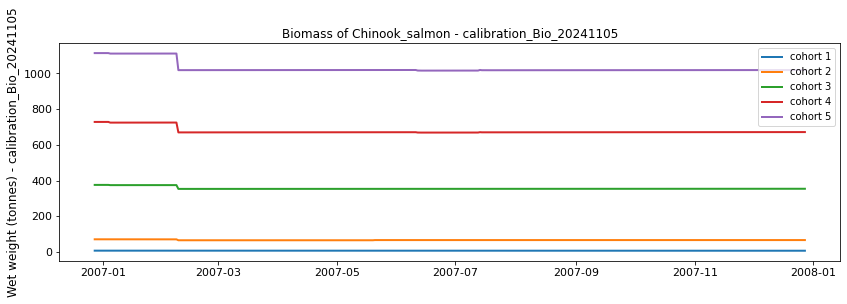

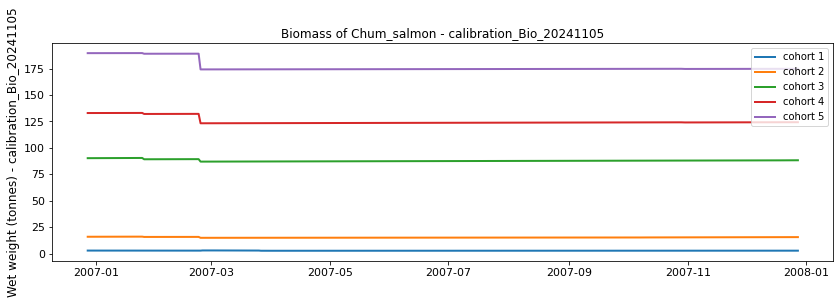

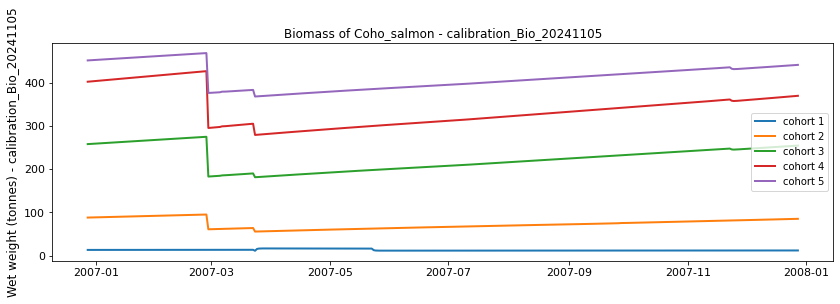

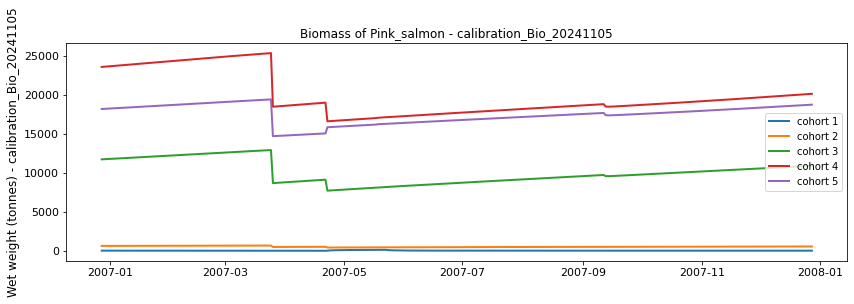

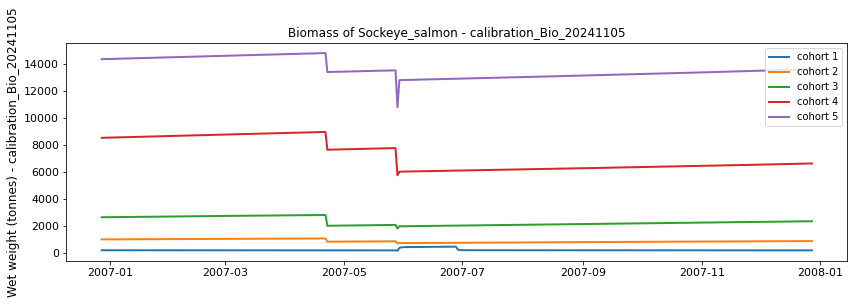

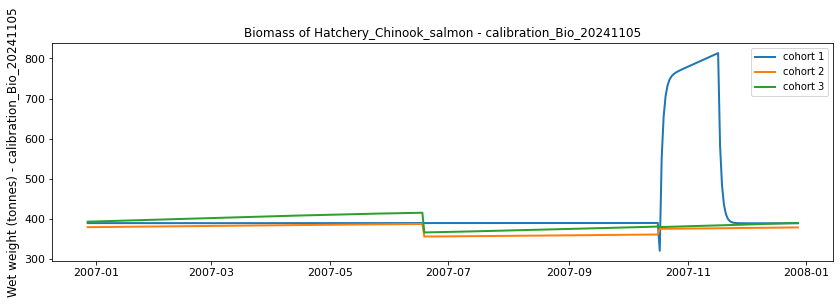

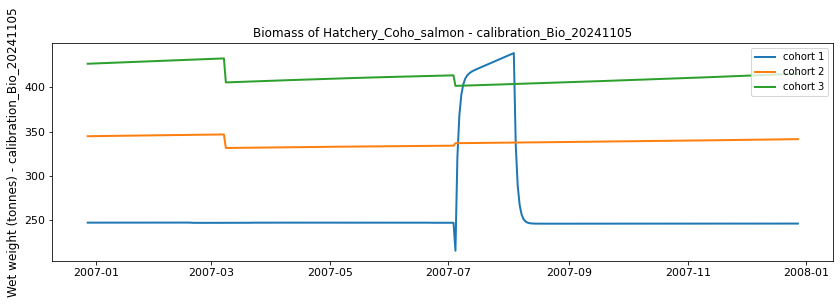

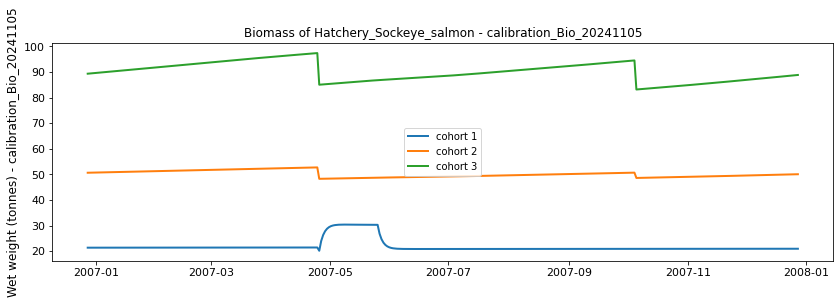

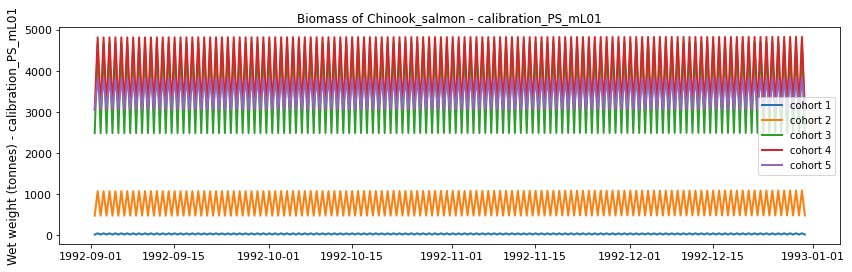

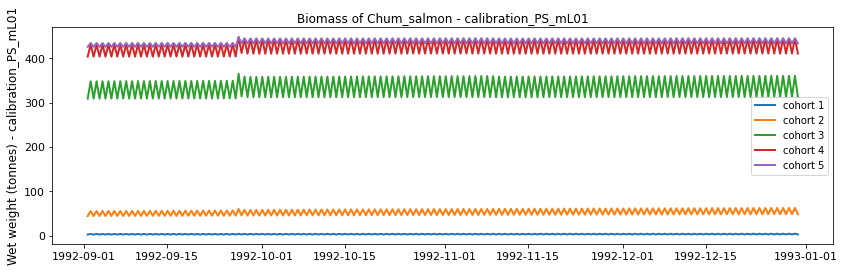

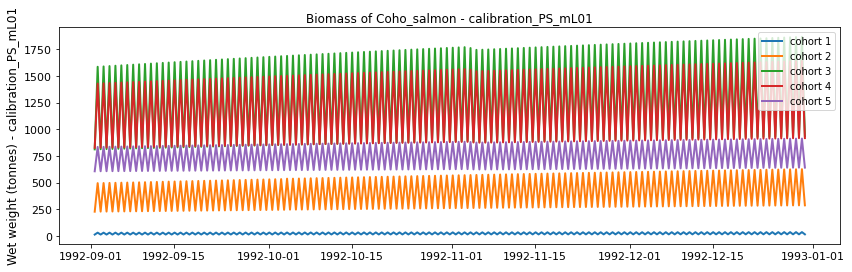

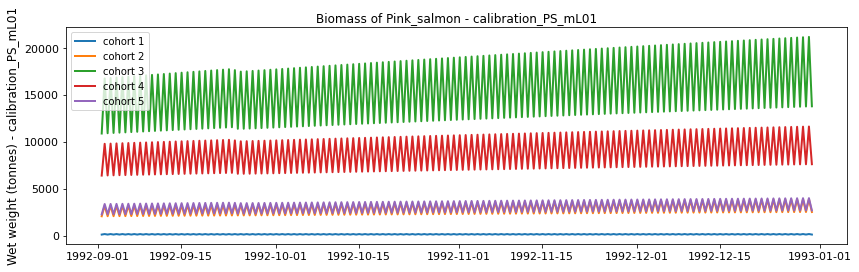

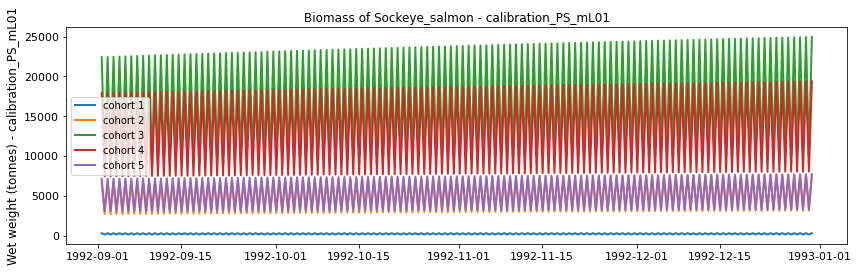

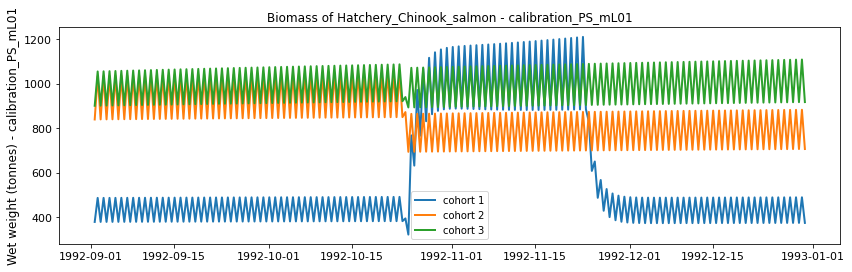

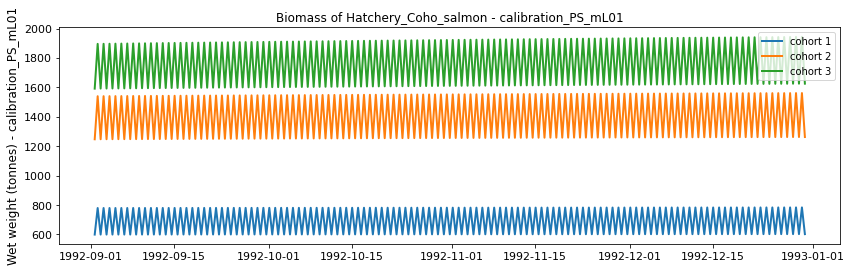

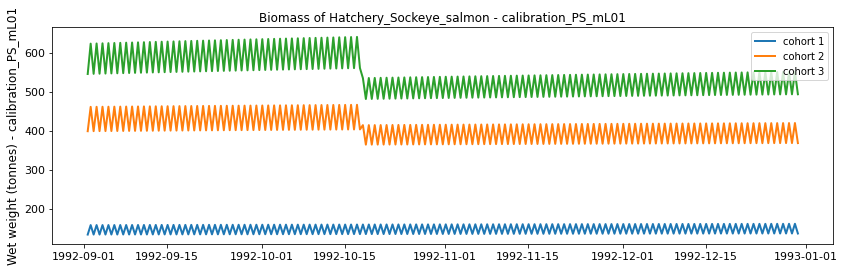

In [44]:
compare_cohorts(groups.salmon, groups.strait_of_georgia)

# Mammals

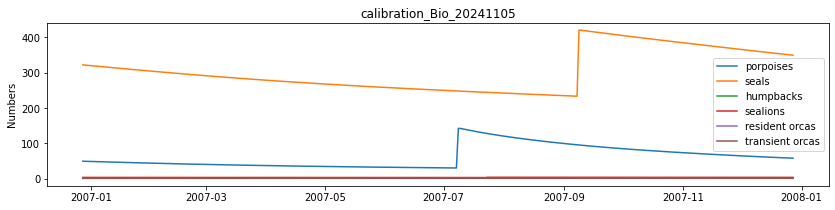

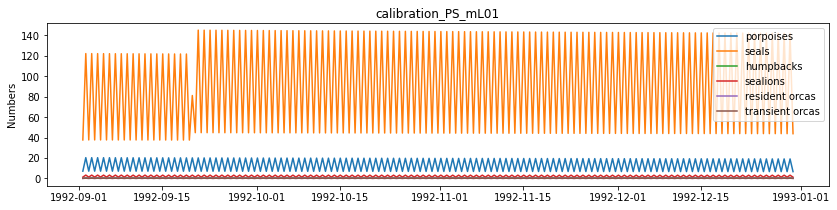

In [48]:
plot_numbers(groups.mammals,strait_of_georgia)

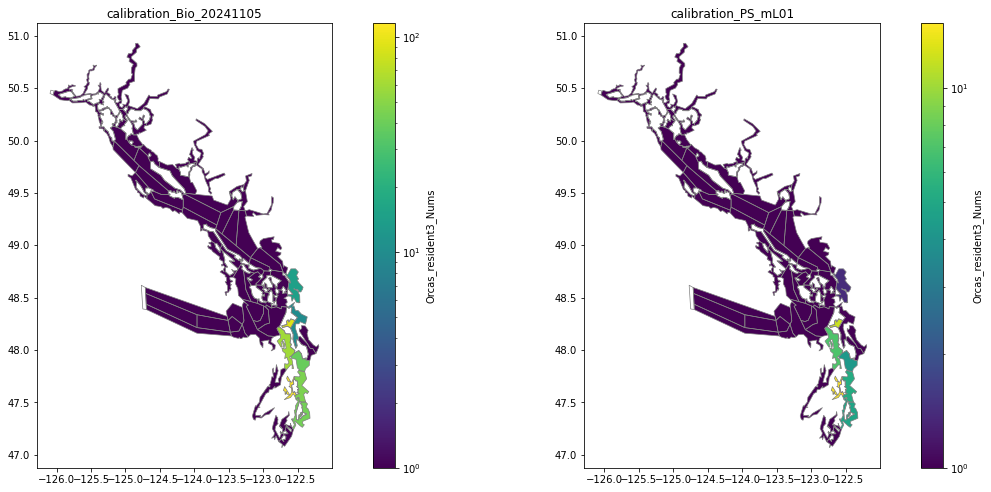

In [49]:
map_water_column('Orcas_resident3_Nums')